In [2]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from os import makedirs, listdir
from os.path import join
import datetime as dt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay


import tensorflow as tf
from tensorflow.keras import optimizers, layers, losses, regularizers 
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
directory = 'pcapcsv/preprocessed/'
datasets = [csv_file for csv_file in listdir(directory) if csv_file.endswith('.csv')]

merged_list = []

for each_csv in datasets:
    file_path = join(directory, each_csv)
    for chunk_df1 in pd.read_csv(file_path, chunksize=10000):
        merged_list.append(chunk_df1)

In [4]:
combined_dataset = pd.concat(merged_list, ignore_index=True)

In [5]:
combined_dataset = combined_dataset.dropna(subset=["Label"])  # Drop rows where Label column is null

In [6]:
combined_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22633845 entries, 1 to 32140644
Data columns (total 11 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   Label          22633845 non-null  object 
 1   Time           22633845 non-null  object 
 2   Proto          22633845 non-null  float64
 3   Seq_Num        21880193 non-null  float64
 4   Ack_Num        21880193 non-null  float64
 5   TCP_Flag       21880193 non-null  object 
 6   TTL            22633845 non-null  float64
 7   Window_Size    21880193 non-null  float64
 8   TCP_Checksum   21880193 non-null  float64
 9   Packet_Length  22633845 non-null  float64
 10  Payload        22633845 non-null  float64
dtypes: float64(8), object(3)
memory usage: 2.0+ GB


In [7]:
combined_dataset.Proto.value_counts()

6.0     21880193
17.0      753652
Name: Proto, dtype: int64

In [8]:
combined_dataset.drop(['Time', 'Proto'], axis=1, inplace=True)

In [9]:
combined_dataset.head()

,Label,Seq_Num,Ack_Num,TCP_Flag,TTL,Window_Size,TCP_Checksum,Packet_Length,Payload
1,DoS attacks-Hulk,1.442254e+09,2.542187e+09,A,128.0,278.0,16795.0,40.0,1.653318
2,DoS attacks-Hulk,1.442254e+09,2.542187e+09,A,128.0,278.0,16795.0,40.0,1.653318
3,DoS attacks-Hulk,1.442254e+09,2.542187e+09,A,128.0,278.0,16795.0,40.0,1.653318
4,DoS attacks-Hulk,1.442254e+09,2.542187e+09,A,128.0,278.0,16795.0,40.0,1.653318
5,DoS attacks-Hulk,1.442254e+09,2.542187e+09,A,128.0,278.0,16795.0,40.0,1.653318


In [10]:
#count_classes = pd.value_counts(combined_dataset['Proto'], sort = True)
#count_classes.plot(kind = 'bar', rot=0)
#plt.title("Label Distribution")
#plt.xlabel("Label")
#plt.ylabel("Frequency")

In [11]:
#combined_dataset = combined_dataset.dropna()

In [12]:
combined_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22633845 entries, 1 to 32140644
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   Label          22633845 non-null  object 
 1   Seq_Num        21880193 non-null  float64
 2   Ack_Num        21880193 non-null  float64
 3   TCP_Flag       21880193 non-null  object 
 4   TTL            22633845 non-null  float64
 5   Window_Size    21880193 non-null  float64
 6   TCP_Checksum   21880193 non-null  float64
 7   Packet_Length  22633845 non-null  float64
 8   Payload        22633845 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.7+ GB


In [13]:

#freq_imputer = SimpleImputer(strategy='most_frequent')

#protocol = combined_dataset.drop('', axis=1)


#combined_dataset.Proto = freq_imputer.fit_transform(protocol)

# Calculate the mode value of column 'B'
mode_value = combined_dataset['TCP_Flag'].mode()[0]

# Fill missing values in column 'B' with the mode value
combined_dataset['TCP_Flag'] = combined_dataset['TCP_Flag'].fillna(mode_value)
#Drop a row where the source port and destination ports are not known

#dataset = dataset.dropna(subset=["Dest_Port", 'Seq_Num', 'Ack_Num', 'TCP_Flag'])


#### It is unusual to have zero as the value of sequence number and acknowledgment number

In [14]:
combined_dataset.Ack_Num = combined_dataset.Ack_Num.fillna(0)#zero_imputer.fit_transform(ack_num)
combined_dataset.Seq_Num = combined_dataset.Seq_Num.fillna(0)#zero_imputer.fit_transform(seq_num)

#### For median imputer

In [15]:
combined_dataset[['TCP_Checksum', 'Window_Size']] = combined_dataset[['TCP_Checksum', 'Window_Size']].fillna(combined_dataset[['TCP_Checksum', 'Window_Size']].median())

In [16]:
ord_encoder = OrdinalEncoder()
combined_dataset['TCP_Flag'] = ord_encoder.fit_transform(combined_dataset[['TCP_Flag']])

In [17]:
combined_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22633845 entries, 1 to 32140644
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   Label          22633845 non-null  object 
 1   Seq_Num        22633845 non-null  float64
 2   Ack_Num        22633845 non-null  float64
 3   TCP_Flag       22633845 non-null  float64
 4   TTL            22633845 non-null  float64
 5   Window_Size    22633845 non-null  float64
 6   TCP_Checksum   22633845 non-null  float64
 7   Packet_Length  22633845 non-null  float64
 8   Payload        22633845 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.7+ GB


In [18]:
combined_dataset.TCP_Flag.value_counts()

0.0     12762861
3.0      4368856
6.0      1847119
11.0     1757816
8.0      1061130
1.0       830053
5.0         4851
2.0          834
9.0          313
4.0            7
10.0           3
7.0            2
Name: TCP_Flag, dtype: int64

In [19]:
# create a dictionary to map the values
label_map = {'Benign': 0, 'DoS attacks-Hulk': 1, 'DDOS attack-HOIC': 1, 'Infilteration': 1, 'SSH-Bruteforce': 1, 'DoS attacks-GoldenEye': 1, 'Brute Force -XSS': 1, 'SQL Injection': 1}

# replace the values in the label column
combined_dataset.Label = combined_dataset['Label'].replace(label_map)

In [20]:
# replace the values in the label column
label = combined_dataset['Label']

#### Normalize the data to [0,1]

In [21]:
#Normalize by columns
def normalize_columns(df, cols):
    for col_name in cols:
        df[col_name] = (df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())
        
    return df

#column = 'Column 1'
#df_sklearn[column] = MinMaxScaler().fit_transform(np.array(df_sklearn[column]).reshape(-1,1))
#for col_name in cols:
#    train_data_norm[col_name] = (df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())

## Sparse Autoencoder

In [22]:
combined_dataset_norm = combined_dataset.loc[combined_dataset.Label == 0]

In [23]:
combined_dataset_abnorm = combined_dataset.loc[combined_dataset.Label == 1]

In [24]:
combined_dataset_norm, combined_dataset_norm2,  = train_test_split(combined_dataset_norm, test_size=0.1, random_state=42)

In [25]:
#combined_dataset_norm.index.values

## Segmentation for CNN Sparse Autoencoder

In [26]:
"""new_dir= 'SAEImageSet/'
#name = "".join([new_dir, "Thu_1_dataset.csv"])

try:
    makedirs(new_dir, exist_ok=True)
except OSError as error:
    print(error)



def row_to_bytes(row):
    # Convert the row to a byte string
    #byte_row = ','.join([str(x) for x in row]).encode('utf-8')
    target_shape = (9, 9) #Desired shape
    byte_lst=[]
    
    for x in row:
        byte_row = str(row).encode('utf-8')
        # Convert the bytes to a NumPy array
        packet_data = np.frombuffer(byte_row, dtype=np.uint8)
        byte_lst.append(packet_data)

    #concatenate=np.concatenate(byte_lst)
    #np.array(concatenate.resize(target_shape))
    #plt.imshow(concatenate, cmap='gray')
    #plt.axis('off')
    #plt.savefig(f'ImageDataset/train/img_{index}.png')
    
    return byte_lst

#def row_to_image(row):
    #image_list=[]
    #target_shape = (11, 11) #Desired shape
    
    #for conc in row:
#    concatenate=np.concatenate(row)
 #   np.array(concatenate.resize(target_shape))
 #   image_list.append(concatenate)
    
  #  return image_list

def row_to_train_image(arr_data, index):
    concatenate = np.concatenate(arr_data)
    target_shape = (9, 9) #Desired shape

    np.array(concatenate.resize(target_shape))
        
    plt.imshow(concatenate)
    plt.axis('off')
    
    for i in index:
        plt.savefig(f'SAEImageSet/normal/img_{i}_normal.png', bbox_inches = 'tight', pad_inches = 0)
        
    print(index)
    return 0
    
def row_to_test_image(arr_data, index, classname):
    print(index)
    concatenate = np.concatenate(arr_data)
    target_shape = (9, 9) #Desired shape

    np.array(concatenate.resize(target_shape))
        
    plt.imshow(concatenate)
    plt.axis('off')
    for i in index:
        plt.savefig(f'SAEImageSet/anormalous/img_{i}_anormalous.png', bbox_inches = 'tight', pad_inches = 0)
    #plt.close()
    
    return 0"""

'new_dir= \'SAEImageSet/\'\n#name = "".join([new_dir, "Thu_1_dataset.csv"])\n\ntry:\n    makedirs(new_dir, exist_ok=True)\nexcept OSError as error:\n    print(error)\n\n\n\ndef row_to_bytes(row):\n    # Convert the row to a byte string\n    #byte_row = \',\'.join([str(x) for x in row]).encode(\'utf-8\')\n    target_shape = (9, 9) #Desired shape\n    byte_lst=[]\n    \n    for x in row:\n        byte_row = str(row).encode(\'utf-8\')\n        # Convert the bytes to a NumPy array\n        packet_data = np.frombuffer(byte_row, dtype=np.uint8)\n        byte_lst.append(packet_data)\n\n    #concatenate=np.concatenate(byte_lst)\n    #np.array(concatenate.resize(target_shape))\n    #plt.imshow(concatenate, cmap=\'gray\')\n    #plt.axis(\'off\')\n    #plt.savefig(f\'ImageDataset/train/img_{index}.png\')\n    \n    return byte_lst\n\n#def row_to_image(row):\n    #image_list=[]\n    #target_shape = (11, 11) #Desired shape\n    \n    #for conc in row:\n#    concatenate=np.concatenate(row)\n #   np.

In [27]:
len(combined_dataset_norm2)

1655153

In [28]:
"""byte_df = combined_dataset_norm2.drop('Label', axis=1).apply(row_to_bytes, axis=1)
index=byte_df.index.values
byte_df.apply(row_to_train_image, index=index)
print('Finish')"""

"byte_df = combined_dataset_norm2.drop('Label', axis=1).apply(row_to_bytes, axis=1)\nindex=byte_df.index.values\nbyte_df.apply(row_to_train_image, index=index)\nprint('Finish')"

In [29]:
"""byte_df = combined_dataset_abnorm.apply(row_to_bytes, axis=1)
index=byte_df.index.values
byte_df.apply(row_to_test_image, index=index)"""

'byte_df = combined_dataset_abnorm.apply(row_to_bytes, axis=1)\nindex=byte_df.index.values\nbyte_df.apply(row_to_test_image, index=index)'

In [30]:
combined_dataset_abnorm = pd.concat([combined_dataset_norm2, combined_dataset_abnorm], ignore_index=True)

In [31]:
len(combined_dataset_abnorm)

7737477

In [32]:
combined_dataset_norm_y = combined_dataset_norm.Label

In [33]:
combined_dataset_norm = combined_dataset_norm.drop('Label', axis=1).astype(float)

In [34]:
combined_dataset_abnorm_y = combined_dataset_abnorm.Label

In [35]:
combined_dataset_abnorm = combined_dataset_abnorm.drop('Label', axis=1).astype(float)

In [36]:
combined_dataset_norm = normalize_columns(combined_dataset_norm, combined_dataset_norm.columns.values)

In [37]:
combined_dataset_abnorm = normalize_columns(combined_dataset_abnorm, combined_dataset_abnorm.columns.values)

In [38]:
combined_dataset_abnorm

,Seq_Num,Ack_Num,TCP_Flag,TTL,Window_Size,TCP_Checksum,Packet_Length,Payload
0,0.435982,0.535331,0.000000,0.496063,0.031327,0.925352,0.000620,0.738751
1,0.935024,0.526787,0.000000,0.496063,0.031266,0.178793,0.000620,0.629304
2,0.017393,0.303264,0.272727,0.393701,0.003952,0.440596,0.002978,0.835279
3,0.968666,0.132067,0.000000,0.496063,0.031266,0.215232,0.000620,0.626113
4,0.939833,0.000000,0.727273,0.417323,0.125002,0.379772,0.000806,0.588947
...,...,...,...,...,...,...,...,...
7737472,0.158270,0.118332,0.272727,0.425197,0.003845,0.624210,0.001210,0.664520
7737473,0.158270,0.118332,0.272727,0.425197,0.003845,0.624210,0.001210,0.664520
7737474,0.158270,0.118332,0.272727,0.425197,0.003845,0.614261,0.001210,0.664520
7737475,0.158270,0.118332,0.272727,0.425197,0.003845,0.614261,0.001210,0.664520


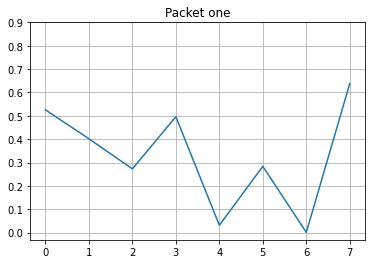

In [39]:
#fig = plt.subplots(nrows=1, ncols=2)
plt.grid()
plt.plot(np.arange(8), combined_dataset_norm.to_numpy()[172])
plt.title("Packet one")
plt.yticks([i/10 for i in range(10)])


plt.show()

In [40]:
combined_dataset_norm = combined_dataset_norm.to_numpy()
combined_dataset_abnorm = combined_dataset_abnorm.to_numpy() 

In [41]:
#combined_dataset_norm = np.where(np.isnan(combined_dataset_norm), 0, combined_dataset_norm)

In [42]:
#combined_dataset_abnorm = np.where(np.isnan(combined_dataset_abnorm), 0, combined_dataset_abnorm)

In [43]:
print(np.isnan(combined_dataset_abnorm).any())

False


In [44]:
class SparseAEAnomalyDetector(Model):
    def __init__(self):
        super(SparseAEAnomalyDetector, self).__init__()
        self.encoder = layers.Dense(32, activation="softmax", activity_regularizer=regularizers.l1_l2(10e-5))

        self.decoder = layers.Dense(8, activation="sigmoid")
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = SparseAEAnomalyDetector()

In [45]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')#, metrics=['accuracy'])
#Strop training when overfitting is detected
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                  patience=5, 
                                                  min_delta=0.0001, 
                                                  mode='auto', 
                                                  verbose=2, 
                                                  baseline=None, 
                                                  restore_best_weights=True)

logdir = join("logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)


In [46]:
EPOCHS = 100
BATCH_SIZE = 256

In [47]:
history = autoencoder.fit(combined_dataset_norm, combined_dataset_norm,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          validation_data=(combined_dataset_abnorm, combined_dataset_abnorm),
          steps_per_epoch=int(np.ceil(len(combined_dataset_norm) / float(BATCH_SIZE))),
          validation_steps=int(np.ceil(len(combined_dataset_abnorm) / float(BATCH_SIZE))),
          shuffle=True,
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100
58189/58189 [==============================] - 90s 2ms/step - loss: 0.3981 - val_loss: 0.3908
Epoch 2/100
58189/58189 [==============================] - 79s 1ms/step - loss: 0.3868 - val_loss: 0.3901
Epoch 3/100
58189/58189 [==============================] - 91s 2ms/step - loss: 0.3863 - val_loss: 0.3893
Epoch 4/100
58189/58189 [==============================] - 88s 2ms/step - loss: 0.3859 - val_loss: 0.3892
Epoch 5/100
58189/58189 [==============================] - 84s 1ms/step - loss: 0.3857 - val_loss: 0.3891
Epoch 6/100
58189/58189 [==============================] - 92s 2ms/step - loss: 0.3856 - val_loss: 0.3889
Epoch 7/100
58189/58189 [==============================] - 79s 1ms/step - loss: 0.3856 - val_loss: 0.3889
Epoch 8/100
58189/58189 [==============================] - 86s 1ms/step - loss: 0.3855 - val_loss: 0.3889
Epoch 9/100
58189/58189 [==============================] - 83s 1ms/step - loss: 0.3855 - val_loss: 0.3888
Epoch 10/100
58189/58189 [====================

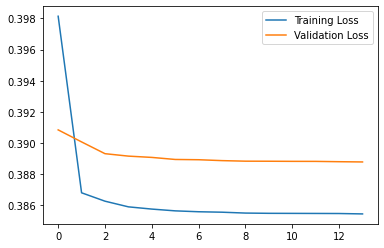

In [48]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('Training_Loss_SA_Sup_AD.png')
plt.show()

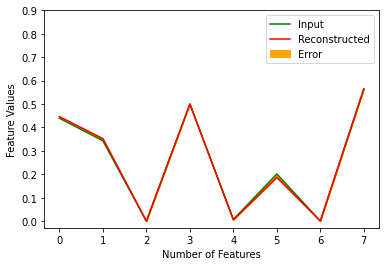

In [49]:
encoded_data = autoencoder.encoder(combined_dataset_norm).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(combined_dataset_norm[12], 'g')
plt.plot(decoded_data[12], 'r')
plt.fill_between(np.arange(8), decoded_data[12], combined_dataset_norm[12], color='orange')
plt.legend(labels=["Input", "Reconstructed", "Error"])
plt.ylabel('Feature Values')
plt.xlabel('Number of Features')
plt.yticks([i/10 for i in range(10)])
plt.savefig("rec_0.png")
plt.show()

In [50]:
#tf.keras.models.save_model(autoencoder, 'tensormodel/Sparse_Autoencoder_Model_RELU.h5')
#history.save_model('Sparse_Autoencoder_Model_RELU.h5')
autoencoder.save_weights('Sparse_Autoencoder_Model_Softmax_MSE.h5')

In [51]:
#autoencoder = tf.saved_model.load('tensormodel/Sparse_Autoencoder_Model_RELU')
#tf.keras.models.load_model('CNNAE.h5') 

In [52]:
reconstructions_train = autoencoder.predict(combined_dataset_norm)

465512/465512 [==============================] - 267s 574us/step


In [53]:
train_loss = tf.keras.losses.binary_crossentropy(reconstructions_train, combined_dataset_norm)

c:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


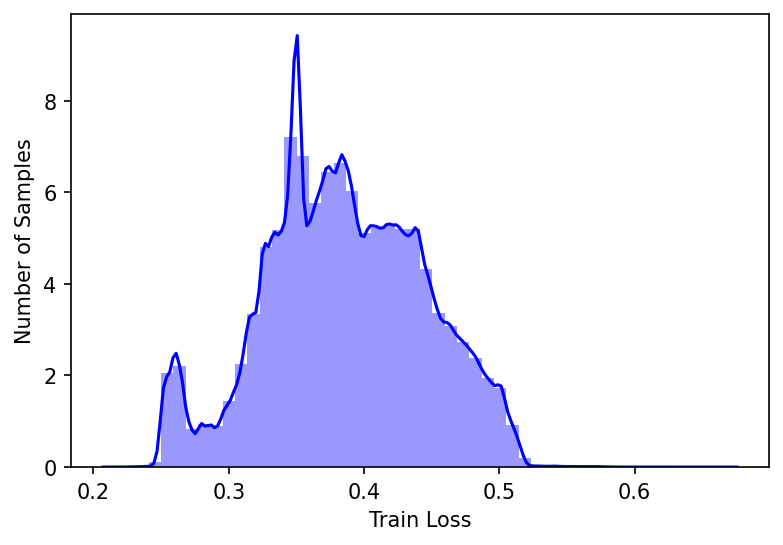

In [54]:
# Plot the histogram using seaborn
plt.subplots(dpi=150)

dist_sns = sns.distplot(train_loss[None,:], color="b")

plt.xlabel("Train Loss")
plt.ylabel("Number of Samples")
plt.savefig("sns_distri.png")

In [55]:
# Compute the median and MAD of the reconstruction error
b = 1.4826
median = np.median(train_loss)
mad = b * np.median(np.abs(train_loss - median))

# Set the threshold based on the median and MAD
k = 3
threshold_median = median + k * mad


print("Threshold median:", threshold_median) 

Threshold median: 0.5672585463325271


In [56]:
threshold_std = np.mean(train_loss) + 2*(np.std(train_loss))
print("Threshold std:", threshold_std) 

Threshold std: 0.5037135877055894


In [57]:
#Threshold using Percentile
l_1, l_0  =  label.value_counts()
threshold_perc =  (l_0/(l_1 + l_0))
print("Threshold percentile:", threshold_perc)

Threshold percentile: 0.2687269440963301


In [58]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.binary_crossentropy(reconstructions, data)
    return reconstructions, loss, tf.math.less(loss, threshold) #Returns the truth value of (loss < threshold) element-wise.

def print_stats(true_labels, predictions):
    print(f"Accuracy = {round(accuracy_score(true_labels, predictions), 2)}")
    print(f"Precision = {round(precision_score(true_labels, predictions), 2)}")
    print(f"Recall = {round(recall_score(true_labels, predictions), 2)}")
    
    

In [59]:
model, rec_loss, pred_ = predict(autoencoder, combined_dataset_abnorm, threshold_std)

In [60]:
#plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.show()

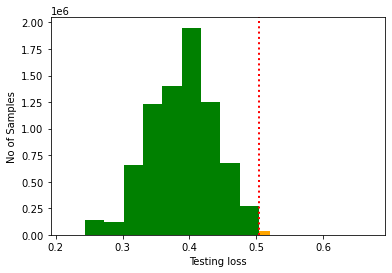

In [61]:
a=np.array(rec_loss[None,:])

anomaly = a[a >= threshold_std]
normal =  a[a < threshold_std]

plt.hist(normal, color='g')
plt.hist(anomaly, color='orange')
plt.xlabel("Testing loss")
plt.ylabel("No of Samples")

plt.axvline(threshold_std, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Anomaly Sample STD.png")
plt.show()

In [62]:
print_stats(combined_dataset_abnorm_y, pred_)

Accuracy = 0.79
Precision = 0.79
Recall = 1.0


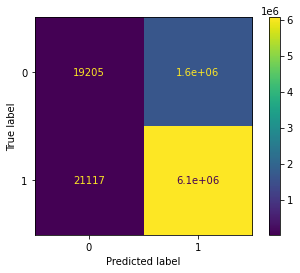

In [63]:
ConfusionMatrixDisplay.from_predictions(combined_dataset_abnorm_y, pred_)
plt.show()

In [112]:
def auprc(dataset, pred_):
    precision, recall, thresholds = precision_recall_curve(dataset, pred_)
    auprc = average_precision_score(dataset, pred_)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)

    return round(auc_precision_recall, 1)


In [113]:
#print(round(auc_precision_recall, 1))
auprc(combined_dataset_abnorm_y.to_numpy(), pred_)

0.9

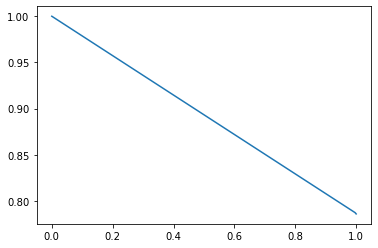

In [66]:
plt.plot(recall, precision, label='AUPRC = %0.2f' % auprc)
plt.show()

In [67]:
#anomaly_shape = tf.math.count_nonzero(pred_)
#anomaly_shape

In [68]:
#normal_shape=pred_.shape - anomaly_shape
#norm = tf.math.equal(pred_, tf.constant(False))
#normal_shape= tf.math.count_nonzero(norm)
#normal_shape

In [69]:
#sns.scatterplot(data=pred_, hue="time")
#anomaly_pd = pd.DataFrame({'anomaly':anomaly})
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#normal_pd = pd.DataFrame({'normal': normal})

#am_plt=plt.scatter(anomaly_pd.index, anomaly_pd['anom'], color='r')
#plt.show()

#nm_plt=plt.scatter(normal_pd.index, normal_pd['norm'], color='g')
#plt.show

#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#sns.scatterplot(anomaly_pd.index, anomaly_pd['anomaly'], y="Anomaly", x='Index', color='red', ax=ax1)
#sns.scatterplot(normal_pd.index, normal_pd['normal'], x='Index', color='green', ax=ax2)
#plt.savefig('scatterplot.png')
#plt.show()

## Isolation Forest Model

In [70]:
train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(combined_dataset.drop('Label', axis=1), label, test_size=0.5, random_state=42)

In [71]:
l_0, l_1 = train_data_y.value_counts()

In [72]:
cont = 1 - (l_1 / (l_1 + l_0))

#percentage = 100 * float(part)/float(whole)

contamination = round(cont, 1)
print(contamination)

0.7


In [73]:
(combined_dataset.head())

,Label,Seq_Num,Ack_Num,TCP_Flag,TTL,Window_Size,TCP_Checksum,Packet_Length,Payload
1,1,1.442254e+09,2.542187e+09,0.0,128.0,278.0,16795.0,40.0,1.653318
2,1,1.442254e+09,2.542187e+09,0.0,128.0,278.0,16795.0,40.0,1.653318
3,1,1.442254e+09,2.542187e+09,0.0,128.0,278.0,16795.0,40.0,1.653318
4,1,1.442254e+09,2.542187e+09,0.0,128.0,278.0,16795.0,40.0,1.653318
5,1,1.442254e+09,2.542187e+09,0.0,128.0,278.0,16795.0,40.0,1.653318


#### Isolation Forest Training

In [74]:
iso_forest = IsolationForest(contamination='auto', n_estimators=100, max_samples='auto', max_features=1.0, n_jobs=-1, bootstrap=False, verbose=0, warm_start=False)

In [90]:
iso_predict = iso_forest.fit_predict(test_data_x)

In [76]:
#iso_predict = iso_forest.predict(test_data_x)

In [91]:
# Convert -1 and 1 to 1 and 0

iso_predict = 1 - ((iso_predict + 1) / 2)

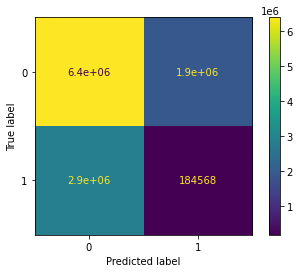

In [98]:
ConfusionMatrixDisplay.from_predictions(test_data_y, iso_predict)
plt.show()

In [100]:
print_stats(test_data_y, iso_predict)

Accuracy = 0.58
Precision = 0.09
Recall = 0.06


In [80]:
##empty_df_iso = pd.DataFrame()

In [81]:
#empty_df_iso['scores']=iso_forest.decision_function(test_data_x.to_numpy())

In [82]:
#empty_df_iso['iso_f_label'] = iso_predict
#outliers = empty_df.loc[empty_df['iso_f_label'] == -1]
#outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
#benign, anomalous = empty_df_iso['iso_f_label'].value_counts()


In [83]:
#target_names= ['benign', 'anomalous']

In [84]:
# create a dictionary to map the values
#label_map ={1: 0, -1:1}

# replace the values in the label column
#empty_df_iso.iso_f_label = empty_df_iso.iso_f_label.replace(label_map)



In [85]:
#print(classification_report(test_data_y.to_numpy(), empty_df_iso.iso_f_label.to_numpy()))

### Local Outlier Factor (LOF) Model

In [104]:
#train_data_x_n = normalize_columns(train_data_x, train_data_x.columns.values)
test_data_x_n = normalize_columns(test_data_x, test_data_x.columns.values)

In [101]:
#del test_data_x_n

In [105]:
test_data_x_n.head()

,Seq_Num,Ack_Num,TCP_Flag,TTL,Window_Size,TCP_Checksum,Packet_Length,Payload
22494494,0.127062,0.861357,0.000000,0.496063,0.031327,0.900221,0.000620,0.597707
19821372,0.491287,0.939800,0.000000,0.496063,0.031266,0.753826,0.000620,0.658946
19123769,0.094252,0.265552,0.000000,0.496063,0.031327,0.153933,0.000620,0.587121
4121696,0.540496,0.322804,0.000000,0.500000,0.003891,0.540185,0.000636,0.606859
1892179,0.823233,0.000000,0.727273,0.500000,0.125002,0.256107,0.000806,0.537198


In [120]:
lof = LocalOutlierFactor(n_neighbors=100, algorithm='auto', leaf_size=100, metric='minkowski', p=2, metric_params=None, contamination=0.5, novelty=False, n_jobs=-1)

In [121]:
lof_pred = lof.fit_predict(test_data_x_n)

In [ ]:
lof_pred = 1 - ((lof_pred + 1)/ 2)

In [313]:
print(print_stats(test_data_y.to_numpy(), lof_pred))

Accuracy = 0.683292446188774
Precision = 0.9923662856525247
Recall = 0.5713336189674593
None


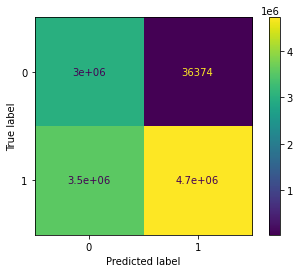

In [312]:
ConfusionMatrixDisplay.from_predictions(test_data_y.to_numpy(), lof_pred)
plt.show()